In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator


E:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
# Dataset path
dataset_path = r'C:\Users\Ahmed Atif\Desktop\MY_data\train'  # hna b7ot dir

# Reading images and labels
images = []
labels = []

# Class names
classes = sorted(os.listdir(dataset_path))
print(f"Classes: {classes}")

class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

for cls in classes:
    cls_folder = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_folder):
        img_path = os.path.join(cls_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        
        # Sharpening Filter
        sharpening_kernel = np.array([[0, -1, 0],
                                      [-1, 5, -1],
                                      [0, -1, 0]])
        img = cv2.filter2D(img, -1, sharpening_kernel)

        # Noise Reduction
        img = cv2.GaussianBlur(img, (3, 3), 0)

        # Contrast Enhancement
        img = cv2.convertScaleAbs(img, alpha=1.2, beta=20)

        images.append(img)
        labels.append(class_to_idx[cls])

images = np.array(images)
labels = np.array(labels)

# Normalization
images = images / 255.0

print(f"Total Loaded Images: {len(images)}")


Classes: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Total Loaded Images: 2300


In [4]:
# hna b3ml agummentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)


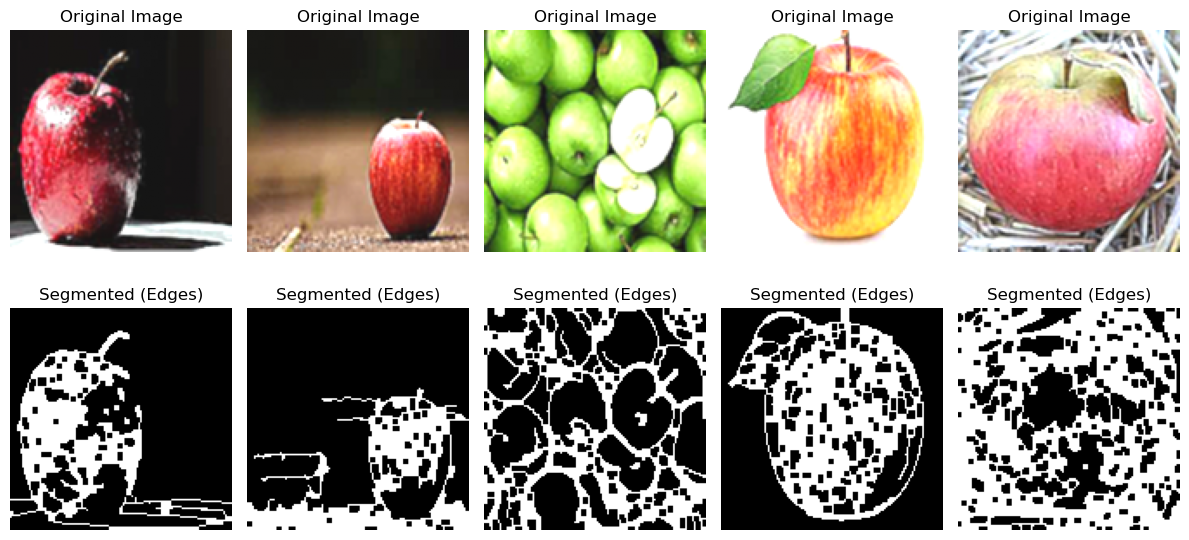

In [5]:
# b3rd images segmentation
plt.figure(figsize=(12,6))
for i in range(5):
    img = images[i]
    img_gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(img_gray, 50, 150)
    kernel = np.ones((3,3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    edges = cv2.erode(edges, kernel, iterations=1)
    
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2,5,i+6)
    plt.imshow(edges, cmap='gray')
    plt.title("Segmented (Edges)")
    plt.axis('off')

plt.tight_layout()
plt.show()


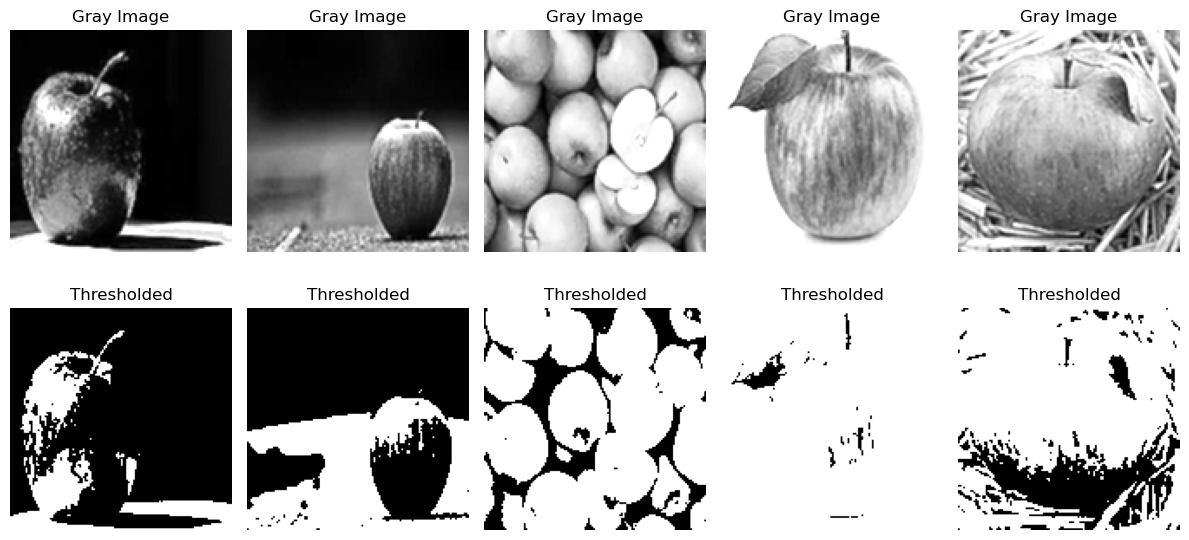

In [6]:
# Thresholding 
plt.figure(figsize=(12,6))
for i in range(5):
    img = images[i]
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Thresholding
    _, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

    plt.subplot(2, 5, i+1)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Gray Image")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(thresh, cmap='gray')
    plt.title("Thresholded")
    plt.axis('off')

plt.tight_layout()
plt.show()


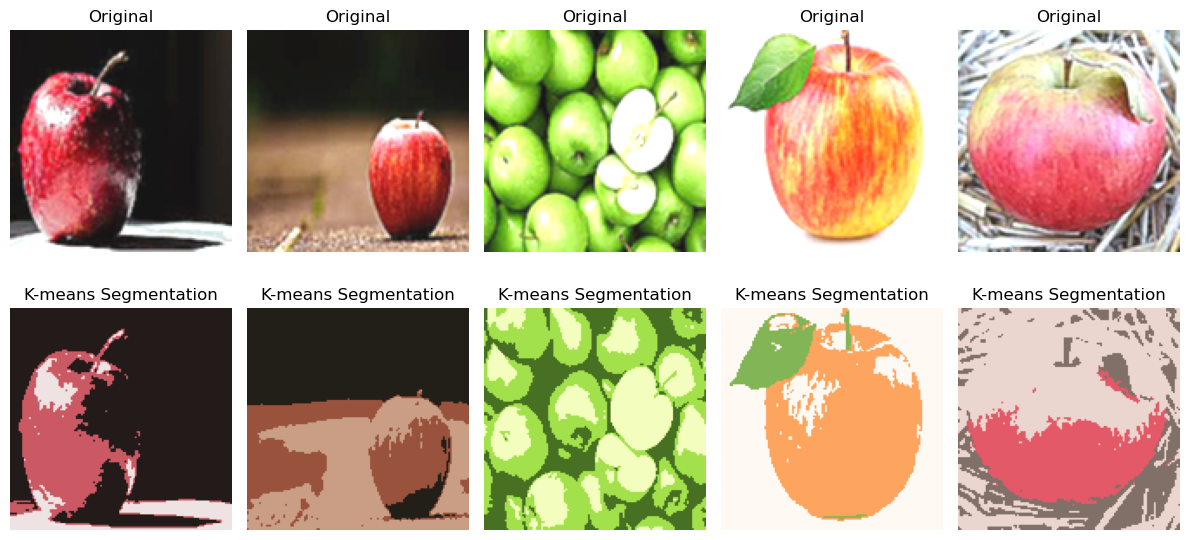

In [7]:
# Region-based Segmentation
def segment_using_kmeans(image, k=3):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape((image.shape))
    return segmented_img

plt.figure(figsize=(12,6))
for i in range(5):
    img = (images[i] * 255).astype(np.uint8)
    segmented = segment_using_kmeans(img, k=3)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(segmented)
    plt.title("K-means Segmentation")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# use HOG features
hog_features = []
for img in images:
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    features, _ = hog(img_gray, orientations=9, pixels_per_cell=(8,8),
                      cells_per_block=(2,2), block_norm='L2-Hys', visualize=True)
    hog_features.append(features)

hog_features = np.array(hog_features)
print(f"HOG Features Shape: {hog_features.shape}")


HOG Features Shape: (2300, 8100)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"Training Images: {len(X_train)}, Testing Images: {len(X_test)}")


Training Images: 1840, Testing Images: 460


In [7]:
#CNN Model
model = Sequential([
    # Block 1
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    # Block 2
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    # Block 3
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    # Block 4
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)     

In [8]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=25
)


Epoch 1/25


58/58 [==============================] - 173s 3s/step - loss: 2.1311 - accuracy: 0.2636 - val_loss: 2.4498 - val_accuracy: 0.1000
Epoch 2/25
58/58 [==============================] - 169s 3s/step - loss: 1.7870 - accuracy: 0.3516 - val_loss: 2.8394 - val_accuracy: 0.1130
Epoch 3/25
58/58 [==============================] - 164s 3s/step - loss: 1.6195 - accuracy: 0.4098 - val_loss: 3.2879 - val_accuracy: 0.1087
Epoch 4/25
58/58 [==============================] - 162s 3s/step - loss: 1.6227 - accuracy: 0.4136 - val_loss: 3.4672 - val_accuracy: 0.1000
Epoch 5/25
58/58 [==============================] - 162s 3s/step - loss: 1.4875 - accuracy: 0.4522 - val_loss: 3.5800 - val_accuracy: 0.1891
Epoch 6/25
58/58 [==============================] - 163s 3s/step - loss: 1.4239 - accuracy: 0.4783 - val_loss: 3.2937 - val_accuracy: 0.1348
Epoch 7/25
58/58 [==============================] - 161s 3s/step - loss: 1.4287 - accuracy: 0.4913 - val_loss: 1.8977 - val_accuracy: 0.2500
Epoch 8/25


In [9]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=classes))


15/15 [==============================] - 11s 765ms/step - loss: 1.1774 - accuracy: 0.6478
Test Accuracy: 64.78%
15/15 [==============================] - 14s 840ms/step
              precision    recall  f1-score   support

       Apple       0.60      0.61      0.60        46
      Banana       0.53      0.59      0.56        46
     avocado       0.59      0.52      0.55        46
      cherry       0.71      0.65      0.68        46
        kiwi       0.88      0.65      0.75        46
       mango       0.80      0.43      0.56        46
      orange       0.88      0.76      0.81        46
  pinenapple       0.45      0.96      0.62        46
strawberries       0.72      0.78      0.75        46
  watermelon       0.73      0.52      0.61        46

    accuracy                           0.65       460
   macro avg       0.69      0.65      0.65       460
weighted avg       0.69      0.65      0.65       460



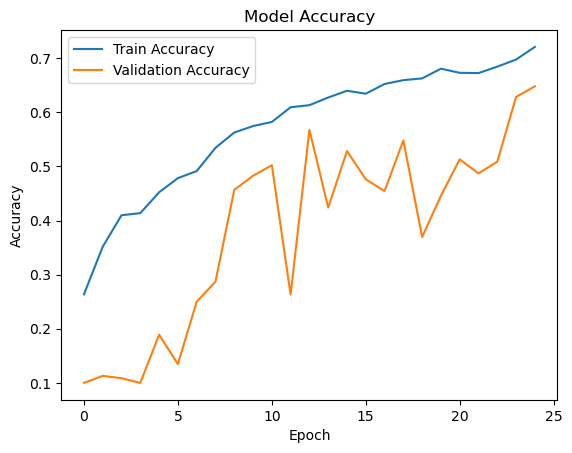

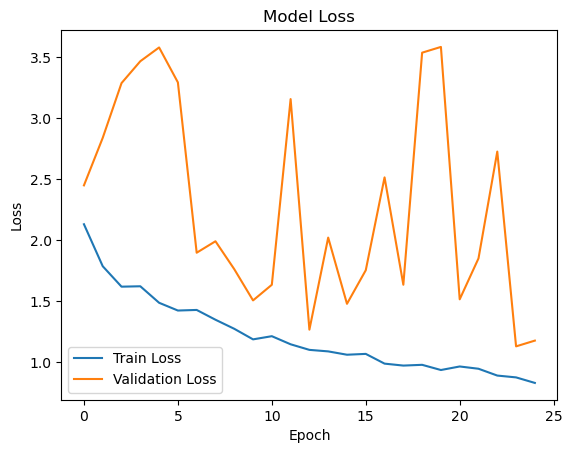

In [10]:
# Accuracy Curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [12]:
model.save('my_model.h5')


E:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
